In [61]:
%env TF_USE_LEGACY_KERAS=0

env: TF_USE_LEGACY_KERAS=0


In [62]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import tf_keras as keras
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread
print("TF Version: " + tf.__version__)
print("TF hub Version: " + hub.__version__)

TF Version: 2.18.0
TF hub Version: 0.16.1


In [63]:
colors = ["yellow", "green", "red", "blue"]

MAX_FILE_SIZE = 105

def mapper(id):
    local_idx = id % MAX_FILE_SIZE
    color_idx = id // MAX_FILE_SIZE
    name = colors[color_idx] + str(local_idx + 1)
    label = colors[color_idx]
    return ["images/" + name + ".jpg", label]

data = list(map(mapper, iter(range(0, 400))))

labels = pd.DataFrame(data, columns=["path", "label"])
labels

,path,label
0,images/yellow1.jpg,yellow
1,images/yellow2.jpg,yellow
2,images/yellow3.jpg,yellow
3,images/yellow4.jpg,yellow
4,images/yellow5.jpg,yellow
...,...,...
395,images/blue81.jpg,blue
396,images/blue82.jpg,blue
397,images/blue83.jpg,blue
398,images/blue84.jpg,blue


In [64]:
colours = labels["label"]
colours = np.array(colours)
unique_colours = np.unique(colours)

In [65]:
boolean_labels = [label == unique_colours for label in colours]

In [66]:
x = labels["path"]
y = boolean_labels
x_train,x_val,y_train,y_val = train_test_split(x, y, test_size=0.2, random_state=42)
x_train[:5], y_train[:2]

(3       images/yellow4.jpg
 18     images/yellow19.jpg
 202     images/green98.jpg
 250       images/red41.jpg
 274       images/red65.jpg
 Name: path, dtype: object,
 [array([False, False, False,  True]), array([False, False, False,  True])])

In [67]:
IMG_SIZE = 224

def process_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image,tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image

In [68]:
def get_image_label(path, label):
    image = process_image(path)
    return (image, label)

In [69]:
process_image(x[42]), tf.constant(y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[6.0023984e-04, 6.6766709e-02, 1.7957184e-01],
         [1.1784716e-02, 7.0428178e-02, 1.8109244e-01],
         [1.4905963e-02, 7.7651061e-02, 1.7204882e-01],
         ...,
         [8.3613414e-01, 8.3849525e-01, 9.5964348e-01],
         [8.4411758e-01, 8.5480171e-01, 9.7637033e-01],
         [8.5598224e-01, 8.7110829e-01, 9.9099624e-01]],
 
        [[6.0023979e-04, 5.9303727e-02, 1.5298119e-01],
         [1.5346140e-02, 6.4645864e-02, 1.6212486e-01],
         [1.2565026e-02, 7.6610647e-02, 1.6410565e-01],
         ...,
         [8.2517010e-01, 8.2909167e-01, 9.4253665e-01],
         [8.2921147e-01, 8.4399724e-01, 9.5952368e-01],
         [8.5826337e-01, 8.6218494e-01, 9.7983199e-01]],
 
        [[0.0000000e+00, 4.9459793e-02, 1.0156064e-01],
         [7.8831511e-03, 5.4381751e-02, 1.1824731e-01],
         [7.7831121e-03, 7.0828333e-02, 1.2743099e-01],
         ...,
         [8.1388545e-01, 8.2230926e-01, 9.4327760e-01],


Now that we've gotten a way to turn our data into tuples of tensors, in the form `(image,label)` let's make a function to turn all of our data into (X and y) into batches

In [70]:
BATCH_SIZE = 32

def create_data_batches(x, y=None, valid_data=False, test=False):
    if test:
        print("Creating test batches...")
        data = tf.data.Dataset.from_tensor_slices(tf.constant(x))
        data_batch = data.map(process_image).batch(BATCH_SIZE)
    elif valid_data:
        print("Creating valid dataset batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    else:
        print("Creating training data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data = data.shuffle(buffer_size=len(x))
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

In [71]:
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val, valid_data=True)
train_images,train_labels = next(train_data.as_numpy_iterator())

Creating training data batches...
Creating valid dataset batches...


## Building a Model

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model
* The output shape (the image labels, in the form of tensors) of our model
* The url of the model we are using from TensorFlow Hub
https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

In [72]:
INPUT_SHAPE = [BATCH_SIZE,IMG_SIZE,IMG_SIZE,3] # Batch, Height, Width, Colour Channels
OUTPUT_SHAPE = len(unique_colours)
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Now we've got our inputs, outputs, and model
Let's put them together into a keras deep learning model

Knowing this, let's create a function that:
* takes the input shape, output shape, and the model we've chosen as params.
* Defines the layers in a keras model in a sequential fashion
* Compiles the model and (says how it should be evaluated and improved)
* Build the model, the kind or the input shape it will be getting
* Returns the model

All of these steps can be found here: https://www.tensorflow.org/guide/keras

In [73]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    model = keras.Sequential([
        keras.layers.GaussianNoise(stddev=0.025),
        hub.KerasLayer(model_url),    
        keras.layers.Dense(units=output_shape, activation="softmax")
    ])    

    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.Adam(),
        metrics=["accuracy"]
    )
    model.build(input_shape)
    return model 
    

In [74]:
model = create_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_4 (Gaussian  (32, 224, 224, 3)         0         
 Noise)                                                          
                                                                 
 keras_layer_4 (KerasLayer)  (32, 1001)                5432713   
                                                                 
 dense_4 (Dense)             (32, 4)                   4008      
                                                                 
Total params: 5436721 (20.74 MB)
Trainable params: 4008 (15.66 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


## Create callbacks

Callbacks are helper functions a model can use during training to do such things as save it's progress, check it's progress, or stop training early if a model stops imroving (and some more)

We'll create two callbacks:
1. One for TensorBoard which helps track our model's progress
2. Another for earl stopping. Prevents our model for training for too long

To set up a tensorboard callback you need three things:
1. Load tensorboard notebook extension ✅
2. Create TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function ✅
3. Visualize our model's training logs with our TensorBoard magic function. We do this after our model training✅

In [75]:
NUM_EPOCH = 8
print(tf.config.list_physical_devices("GPU"))

[]


In [76]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4)

In [77]:
def train_model():
    model = create_model()
    model.fit(
        x=train_data,
        epochs=NUM_EPOCH,
        validation_data=val_data,
        validation_freq=1,
        callbacks=[early_stopping])
    return model

In [78]:
model = train_model()

Epoch 1/8
10/10 [==============================] - 5s 265ms/step - loss: 0.8145 - accuracy: 0.6687 - val_loss: 0.2185 - val_accuracy: 0.9500
Epoch 2/8
10/10 [==============================] - 2s 226ms/step - loss: 0.1116 - accuracy: 0.9969 - val_loss: 0.0602 - val_accuracy: 1.0000
Epoch 3/8
10/10 [==============================] - 2s 226ms/step - loss: 0.0313 - accuracy: 1.0000 - val_loss: 0.0324 - val_accuracy: 1.0000
Epoch 4/8
10/10 [==============================] - 2s 236ms/step - loss: 0.0175 - accuracy: 0.9969 - val_loss: 0.0245 - val_accuracy: 1.0000
Epoch 5/8
10/10 [==============================] - 2s 230ms/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.0199 - val_accuracy: 1.0000
Epoch 6/8
10/10 [==============================] - 2s 229ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.0168 - val_accuracy: 1.0000


In [79]:
preds = model.predict(val_data, verbose=1)
preds

3/3 [==============================] - 1s 121ms/step


array([[3.11622079e-02, 9.25646782e-01, 2.16898769e-02, 2.15011630e-02],
       [7.97248445e-04, 3.28845717e-03, 9.94625747e-01, 1.28855812e-03],
       [1.78249567e-04, 5.62484667e-04, 1.61927805e-04, 9.99097347e-01],
       [9.73446367e-06, 9.76869123e-05, 9.99874830e-01, 1.77360835e-05],
       [8.02022696e-04, 6.45677745e-03, 4.02151514e-03, 9.88719761e-01],
       [2.25344836e-03, 8.07218440e-03, 3.76102026e-03, 9.85913336e-01],
       [9.96261656e-01, 2.00246577e-04, 3.28668812e-03, 2.51429854e-04],
       [8.99688690e-04, 5.21061011e-03, 2.42493185e-03, 9.91464794e-01],
       [3.25965625e-03, 9.00769755e-02, 9.01423573e-01, 5.23986667e-03],
       [2.40730727e-03, 9.91868734e-01, 3.52633116e-03, 2.19757552e-03],
       [4.23438934e-04, 5.50014991e-03, 9.67498927e-04, 9.93108869e-01],
       [9.83742774e-01, 4.12517274e-03, 7.35323550e-03, 4.77878097e-03],
       [2.13428354e-03, 2.53265854e-02, 1.82954781e-02, 9.54243660e-01],
       [9.54510251e-05, 5.49290817e-05, 3.87635810e

In [80]:
def get_pred_label(prediction_probabilites):
    return unique_colours[np.argmax(prediction_probabilites)]

pred_label = get_pred_label(preds[8])
pred_label


'red'

#Create a function to unbatch a batch dataset

Since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and compare those predictions to the validation labels

In [81]:
def unbatchify_data(data_batch):
    images = []
    labels = []
    for image,label in data_batch.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(label)
    return images, labels

val_images, val_labels = unbatchify_data(val_data)

Now we have ways to get:

* Prediction Labels
* Validation Labels (truth labels)
* Validation Images

Let's make some functions to make this all a bit more visual

We'll create a function which:
* takes an array of prediction probabilities, an array of truth labels, and an array of images and an integer
* Convert prediction probabilities to a predicted label
* Plot the predicted label, it's predicted probability, the truth label, and the target image on a single plot

green


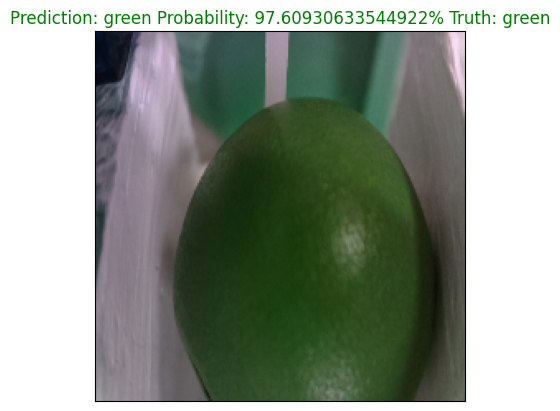

In [82]:
def plot_pred(pred_probs, lbls, imgs, n=1):
    pred_prob, true_label, image = pred_probs[n], lbls[n], imgs[n]
    pred_label = get_pred_label(pred_prob)
    true_label = get_pred_label(true_label)

    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    print(pred_label)

    if pred_label == true_label:
        color = "green"
    else:
        color = "red"

    plt.title(f"Prediction: {pred_label} Probability: {np.max(pred_prob*100)}% Truth: {true_label}", color = color)


plot_pred(pred_probs=preds, lbls=val_labels, imgs=val_images, n=36)

Now we've got one function to visualize our model's top prediction.

Let's make another for our model's top ten predictions

The function will:
* the input from prediction probabilities array ✅
* ground truth array ✅
* an integer ✅
* Find the predicted label with `get_pred_label()` ✅
* Find the top 10:
 * Prediction probabilities✅
 * prediction probabilities indexes✅
 * prediction probability values✅
 * prediction labels✅
* plot the top 10 prediction values and labels, colour coding the true and false predictions ✅

In [83]:
def plot_pred_conf(pred_probs, lbls, n=1):
    pred_prob, true_label = pred_probs[n], lbls[n]
    true_label = get_pred_label(true_label)

    top_10_pred_indices = pred_prob.argsort()[-10:][::-1]
    top_10_pred_values = pred_prob[top_10_pred_indices]
    top_10_pred_labels = unique_colours[top_10_pred_indices]

    length = len(top_10_pred_labels)
    top_plot = plt.bar(np.arange(length), top_10_pred_values, color="grey")
    plt.xticks(np.arange(length), labels=top_10_pred_labels, rotation="vertical")
    
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels) == true_label].set_color("green")
    else:
        pass

green
red
yellow
red
yellow
yellow
blue
yellow
red


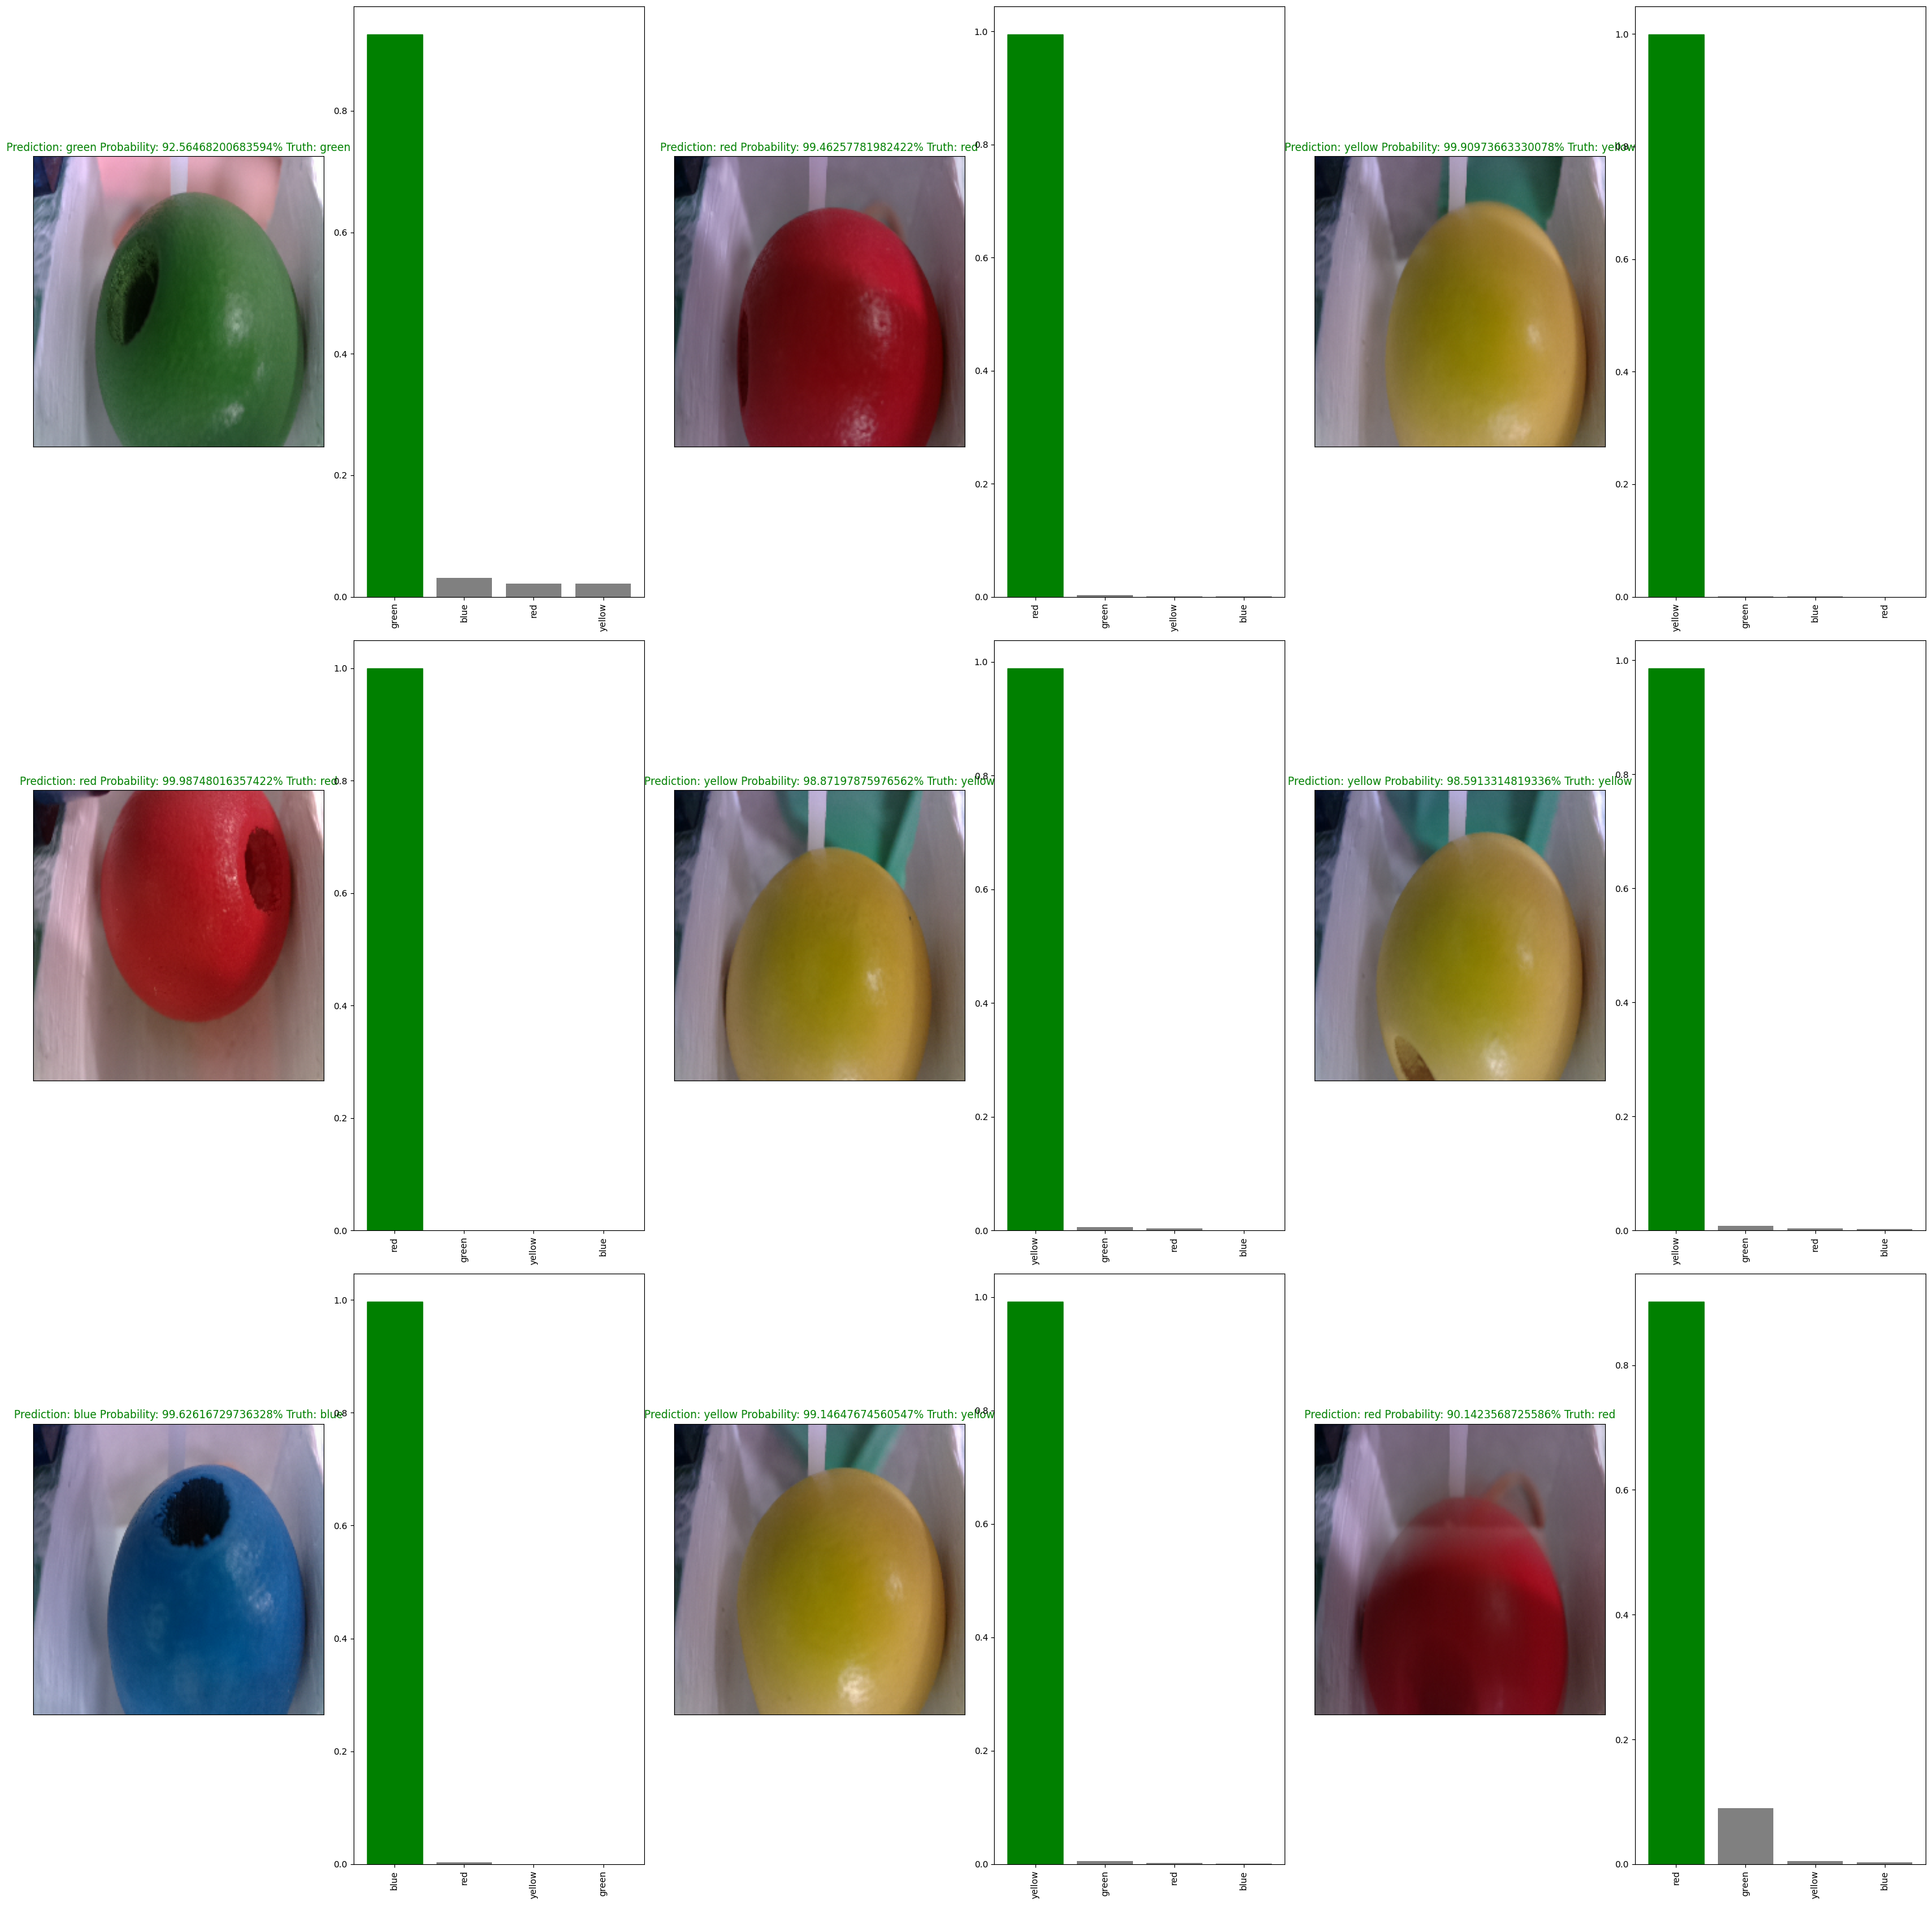

In [84]:
i_multiplier = 0
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize = (10*num_cols, 10*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, num_cols*2,2*i+1)

    plot_pred(preds, val_labels, val_images, n = i+i_multiplier)
    plt.subplot(num_rows, num_cols*2, 2*i+2)

    plot_pred_conf(preds, val_labels, n = i+i_multiplier)
    plt.tight_layout(h_pad = 1.0)
    plt.show

In [85]:
def save_model(model):
    model_path = os.path.join(os.getcwd(), "model.h5")
    print(f"Saving model to {model_path}")
    model.save(model_path)

Now we've got a functions to save a trained model, so let's run it

In [86]:
save_model(model)

Saving model to c:\Users\jribi\Projects\Python\tej4m-colored-ball-sorter\model.h5


c:\Users\jribi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
